In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from wordcloud import WordCloud
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

<a id = '2.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Importing dataset </strong></p>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn import metrics

data=pd.read_csv('../app-rating-competition/train.csv')

def rename_columns(dataframe):
    reformated_df = dataframe.rename(
        columns={"X0": "App", "X1": "Category", "X2": "Reviews", "X3": "Size",
                 "X4": "Installs", "X5": "Type", "X6": "Price", "X7": "Content Rating",
                 "X8": "Genres", "X9": "Last Updated", "X10": "Current Ver",
                 "X11": "Android Ver", "Y": "Rating"})
    return reformated_df

data = rename_columns(data)

In [ ]:
data.head()

In [ ]:
# Take a sample of 5
data.sample(5)

In [ ]:
data.shape

In [ ]:
data.columns

In [ ]:
#The described method will help to see how data has been spread for numerical values.
# We can clearly see the minimum value, mean values, different percentile values, and maximum values.
data.describe(include='all').T

In [ ]:
#info() is used to check the Information about the data and the datatypes of each respective attribute.
data.info()

In [ ]:
data[~data.Reviews.str.isnumeric()]

* We could have converted it into interger like we did for Size but the data for this App looks different. It can be noticed that the entries are entered wrong  We could fix it by setting Category as nan and shifting all the values, but deleting the sample for now.

In [ ]:
data=data.drop(data.index[8653])

In [ ]:
data["Reviews"] = data["Reviews"].astype(int)

In [ ]:
data.info()  

* [Size](#12.0)

* It can be seen that data has metric prefixes (Kilo and Mega) along with another string. Replacing k and M with their values to convert values to numeric.

In [ ]:
data['Size'].unique()

* Remove all characters from size and convert it to float

In [ ]:
data['Size']=data['Size'].str.replace('M','000')
data['Size']=data['Size'].str.replace('k','')
#apps['size']=apps['size'].str.replace('.','')
data['Size']=data['Size'].replace("Varies with device",np.nan)
data['Size']=data['Size'].astype('float')
data['Size']

* There is a problem!! There are some applications size in megabyte and some in kilobyte


In [ ]:
###### Convert mega to kilo then convert all to mega
for i in data['Size']:
    if i < 10:
        data['Size']=data['Size'].replace(i,i*1000)
data['Size']=data['Size']/1000
data['Size']

In [ ]:
data.info()

* [Installs](#13.0) &  [Price](#13.0)


In [ ]:
data['Installs'].unique()

In [ ]:
data['Price'].unique()

In [ ]:
items_to_remove=['+',',','$']
cols_to_clean=['Installs','Price']
for item in items_to_remove:
    for col in cols_to_clean:
        data[col]=data[col].str.replace(item,'')
data.head()

In [ ]:
data.Installs.unique()

In [ ]:
data['Price'].unique()

In [ ]:
data[data['Price']=='Everyone']

In [ ]:
data['Installs']=data['Installs'].astype('int')
data['Price']=data['Price'].astype('float')
data.info()

* [last updated](#12.0)

In [ ]:
#### Change Last update into a datetime column
data['Last Updated'] = pd.to_datetime(data['Last Updated'])
data['Last Updated']

In [ ]:
data['Updated_Day']=data['Last Updated'].dt.day
data['Updated_Month']=data['Last Updated'].dt.month
data['Updated_Year']=data['Last Updated'].dt.year

In [ ]:
data.drop('Last Updated', axis=1, inplace=True)

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
null = pd.DataFrame({'Null Values' : data.isna().sum().sort_values(ascending=False), 'Percentage Null Values' : (data.isna().sum().sort_values(ascending=False)) / (data.shape[0]) * (100)})
null

In [ ]:
null_counts = data.isna().sum().sort_values(ascending=False)/len(data)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

* I Clean missing values using Random Value Imputation Because This the best way to To maintain distrbuation For each feature.

In [ ]:
### lets create a function so that I can easily do it for all features
def Random_value_imputation(feature):
    random_sample=data[feature].dropna().sample(data[feature].isnull().sum())               
    random_sample.index=data[data[feature].isnull()].index
    data.loc[data[feature].isnull(),feature]=random_sample

In [ ]:
for col in data:
    Random_value_imputation(col)

In [ ]:
null = pd.DataFrame({'Null Values' : data.isna().sum().sort_values(ascending=False), 'Percentage Null Values' : (data.isna().sum().sort_values(ascending=False)) / (data.shape[0]) * (100)})
null

In [ ]:
null_counts = data.isna().sum().sort_values(ascending=False)/len(data)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

<a id = '6.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>delete data duplicated</strong></p>

In [ ]:
duplicate = data.duplicated()
print(duplicate.sum())

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
duplicate = data.duplicated()
print(duplicate.sum())

<a id = '5.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong> Extract Numerical & Categorical Features</strong></p> 

In [ ]:
num_features=[col for col in data.columns if data[col].dtype!='O']
num_features

In [ ]:
num_data = data[num_features]
num_data.head()

In [ ]:
cat_features=[col for col in data.columns if data[col].dtype=='O']
cat_features

In [ ]:
categorical=data[cat_features]
categorical.head()

<a id = '7.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Check Qutliers</strong></p>

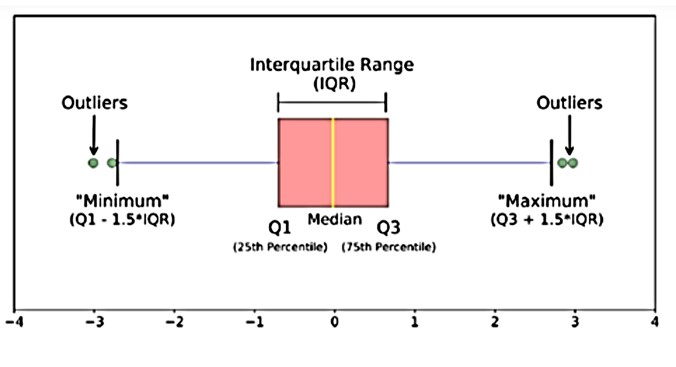

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.10)
    quartile3 = dataframe[variable].quantile(0.90)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
def has_outliers(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].any(axis=None):
        print(variable, "yes")
    print(variable, "no")

In [ ]:
for col in num_data.columns:
    has_outliers(num_data, col)

In [ ]:
plt.figure(figsize=(22,18))
for i,col in enumerate(num_data.columns):
    plt.subplot(4,9,i+1)
    sns.boxplot(num_data[col])

In [ ]:
## function to get ride of qutliers
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
replace_with_thresholds(num_data, num_data.columns)

In [ ]:
for col in num_data.columns:
    has_outliers(num_data, col)

In [ ]:
plt.figure(figsize=(22,18))
for i,col in enumerate(num_data.columns):
    plt.subplot(4,9,i+1)
    sns.boxplot(num_data[col])

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Exploratory Data Analysis (EDA)</strong></p>

###  What is EDA ?
is an approach for data analysis that emeploys a variety of technics (mostly graphical) to  
*  maximize insight into a dataset
*   uncover underlying structure     
*   extract important variables      
*   answer questions 

### EDA Checklist
1. What question(s) are you trying to solve ? 
2. What kind of data do you have and how do you treat different types? 
3. What do you get after visualize your data?
4. What is your observation 

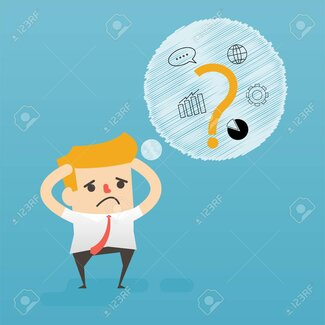

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Category Column</strong></p>

In [ ]:
categorical['Category'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(x='Category',data=data)
plt.xticks(rotation=70)

In [ ]:
plt.subplots(figsize=(25,15))
wordcloud = WordCloud(
                          background_color='black',
                          width=1920,
                          height=1080
                         ).generate(" ".join(data.Category))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
Category1 = data[data.Category=="GAME"].Rating
Category2 = data[data.Category=="FAMILY"].Rating
Category3 = data[data.Category=="MEDICAL"].Rating

fig = go.Figure()
fig.add_trace(go.Box(x=Category1, name='GAME'))
fig.add_trace(go.Box(x=Category2, name='FAMILY'))
fig.add_trace(go.Box(x=Category3, name='MEDICAL'))

fig.show()

### Category vs Rating Analysis

In [ ]:
plt.figure(figsize=(20,15))
sns.boxplot(y='Rating',x='Category',data = data.sort_values('Rating',ascending=False))
plt.xticks(rotation=80)

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Type Column</strong></p>

In [ ]:
categorical['Type'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = (8,5)
sns.countplot(x='Type',data=data)
plt.xticks(rotation=70)

In [ ]:
data["Type"].value_counts().plot.pie(autopct = "%1.1f%%")

### Type vs Rating Analysis

In [ ]:
plt.figure(figsize=(15,8))
sns.catplot(y='Rating',x='Type',data = data.sort_values('Rating',ascending=False),kind='boxen')

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Content Rating Column</strong></p>

In [ ]:
categorical['Content Rating'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(x='Content Rating',data=data)
plt.xticks(rotation=70)

In [ ]:
# pie chart
values = data['Content Rating'].value_counts()
labels = ['Everyone', 'Teen', 'Mature 17+','Everyone 10+','Adults only 18+','Unrated']

fig, ax = plt.subplots(figsize = (12, 8), dpi = 100)
explode = (0,0,0,0,0,.02)

patches, texts, autotexts = ax.pie(values, labels = labels, autopct = '%1.2f%%', shadow = True,
                                   startangle = 0, explode = explode)

plt.setp(texts, color = 'grey')
plt.setp(autotexts, size = 15, color = 'white')
autotexts[1].set_color('black')
plt.show()

### Content Rating vs Rating Analysis

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(y='Rating',x='Content Rating',data = data.sort_values('Rating',ascending=False))
plt.xticks(rotation=90)

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x="Content Rating", y="Installs", hue="Type", data=data)

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Genres Column</strong></p>

In [ ]:
categorical['Genres'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(x='Genres',data=data)
plt.xticks(rotation=90)

### Content Rating vs Genres Analysis

In [ ]:
plt.figure(figsize=(20,15))
sns.boxplot(y='Rating',x='Genres',data = data.sort_values('Rating',ascending=False))
plt.xticks(rotation=90)

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Current Ver Column</strong></p>

In [ ]:
categorical['Current Ver'].value_counts()

<a id = '8.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #008000; border-radius: 5px 5px;"><strong>Android Ver Column</strong></p>

In [ ]:
categorical['Android Ver'].value_counts()

In [ ]:
plt.rcParams['figure.figsize'] = (20, 10)
sns.countplot(x='Android Ver',data=data)
plt.xticks(rotation=30)

### Content Rating vs Android Ver Analysis

In [ ]:
plt.figure(figsize=(20,15))
sns.boxplot(y='Rating',x='Android Ver',data = data.sort_values('Rating',ascending=False))
plt.xticks(rotation=90)

### Defining violin and scatter plot & kde_plot functions

In [ ]:
def violin(col):
    fig = px.violin(data, y=col, x="Type", color="Type", box=True , template = 'plotly_dark')
    return fig.show()

def scatters(col1,col2):
    fig = px.scatter(data, x=col1, y=col2, color="Type" ,template = 'plotly_dark')
    return fig.show()

def kde_plot(feature):
    grid = sns.FacetGrid(data, hue="Type",aspect=2)
    grid.map(sns.kdeplot, feature)
    grid.add_legend()

* kde_plot Analysis

In [ ]:
kde_plot('Rating')

In [ ]:
kde_plot('Updated_Day')

In [ ]:
kde_plot('Size')

In [ ]:
kde_plot('Updated_Month')

In [ ]:
kde_plot('Price')

In [ ]:
kde_plot('Updated_Year')

* scatter plot Analysis

In [ ]:
scatters('Price', 'Updated_Year')

In [ ]:
scatters('Size', 'Rating')

In [ ]:
scatters('Size', 'Installs')

In [ ]:
scatters('Updated_Month', 'Installs')

In [ ]:
scatters('Reviews', 'Rating')

In [ ]:
scatters('Rating', 'Price')

 * violin plot Analysis

In [ ]:
violin('Rating')

In [ ]:
violin('Reviews')

In [ ]:
violin('Size')

In [ ]:
violin('Installs')

In [ ]:
violin('Price')

In [ ]:
violin('Updated_Month')

In [ ]:
violin('Updated_Year')

In [ ]:
freq= pd.Series()
freq=data['Updated_Year'].value_counts()
freq.plot()
plt.xlabel("Dates")
plt.ylabel("Number of updates")
plt.title("Time series plot of Last Updates")

<a id = '9.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Check Co-relation</strong></p>


In [ ]:
corelation = pd.DataFrame({'corelation' : data.corr()["Rating"].abs().sort_values(ascending=False)[1:]})
corelation

In [ ]:
plt.figure(figsize=(10,8))
corelation = data.corr()
sns.heatmap(corelation,annot=True ,linewidths=0.5,linecolor="black", fmt= '.1f' ,cmap='gray_r')

<a id = '6.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Separate dependent & independent features</strong></p>

In [ ]:
y=data['Rating']
X=num_data
cols=X.columns
cols

In [ ]:
X

<a id = '7.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Splitting Dataset</strong></p>


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,train_size=0.75,random_state=0)

In [ ]:
# Import Libraries
from sklearn.preprocessing import StandardScaler

In [ ]:
#Creating a StandardScaler object to normalize the X train and test set feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)


<a id = '13.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Defining function For ML model</strong></p>

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
def predict(ml_model):          
    model=ml_model.fit(X_train,y_train)
    print('Training score : {}'.format(model.score(X_train,y_train)))
    print('\n')
    y_prediction=model.predict(X_test)
    print('Testing score : {}'.format(model.score(X_test,y_prediction)))
    print('\n')

    print('predictions are: \n {}'.format(y_prediction[:10]))
    print('\n')
    r2_score=metrics.r2_score(y_test,y_prediction)
    print('r2 score: {}'.format(r2_score))
    print('MAE:',metrics.mean_absolute_error(y_test,y_prediction))
    print('MSE:',metrics.mean_squared_error(y_test,y_prediction))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_prediction)))


<a id = '12.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>Gradient Boosting</strong></p> 


In [ ]:
predict(GradientBoostingRegressor())

<a id = '9.0'></a>
<p style = "font-size : 35px; color : #E0FFFF ; font-family : 'Comic Sans MS'; text-align : center; background-color : #4682B4; border-radius: 5px 5px;"><strong>If you found this notebook helpful or you just liked it , some upvotes would be very much appreciated - That will keep me motivated to update it on a regular basis</strong></p>
